In [1]:
using Pkg
Pkg.activate("../Tambo/")
Pkg.instantiate()
using Tambo

  Activating project at `~/research/TAMBO-MC/Tambo`


In [2]:
using Plots
using JLD2
using StaticArrays
using StatsBase

In [3]:
include("../figures/paperstyle.jl")

no_bg_dark! (generic function with 1 method)

In [4]:
config_f = jldopen("../resources/example_config.jld2")
const config = SimulationConfig(; Dict(k=>v for (k, v) in config_f["config"] if k != :geo_spline_path)...)
const geo = Tambo.Geometry(config)
const plane = Tambo.Plane(whitepaper_normal_vec, whitepaper_coord, geo)
const altmin = 1.8925255158436627units.km
const altmax = 4.092525515843662units.km

2.0739818168780746e10

## First, we have to load up the data, and make our array

In [5]:
jldf = jldopen("../resources/example_hit_maps.jld2")
key = "2000.0_100.0"
hit_maps = jldf[key]

array_length = parse(Float64, split(key, '_')[1])
spacing = parse(Float64, split(key, '_')[2])

modules = Tambo.make_detector_array(
    whitepaper_coord,
    array_length * units.m,
    spacing * units.m,
    altmin,
    altmax,
    plane,
    geo
);

## Utility functions

### Finds the time window for an event

In [6]:
function find_time_range(hit_map)
    tmin, tmax = Inf, -Inf
    for (idx, evts) in hit_map
        for evt in evts
            tmin = minimum([evt.time, tmin])
            tmax = maximum([evt.time, tmax])
        end
    end
    return tmin, tmax
end

find_time_range (generic function with 1 method)

### These functions allow us to plot background contour map

You can adjust the color map that is used by playing with the `contour_color` argument.
Predefined color maps can be found [here](https://docs.juliaplots.org/latest/generated/colorschemes/). Otherwise, you can adjust the boundaries by changing `xmin`, `xmax`, `ymin`, and `ymax`.
These are always relative to the center of the detector, but be careful not to make these larger than about 10km since our spline does not extend extremely far.

In [7]:
function plot_topographic_map!(
    plt,
    geo;
    xmin=-2.5units.km,
    xmax=2.5units.km,
    ymin=-2.5units.km,
    ymax=2.5units.km,
    contour_color=palette(:lapaz)
    
)
    plot!(
        plt,
        size=(500, 500),
        xlimits=(xmin, xmax)./units.km,
        ylimits=(ymin, ymax)./units.km,
        colorbar_title="Altitude [km]",
        xlabel=L"x~\left[\mathrm{km}\right]",
        ylabel=L"y~\left[\mathrm{km}\right]"
    )
    
    contour_xs = LinRange(xmin, xmax, 201)
    contour_ys = LinRange(ymin, ymax, 200)
    
    contour!(
        plt,
        contour_xs ./ units.km,
        contour_ys ./ units.km,
        @. (geo(contour_xs', contour_ys) + geo.tambo_offset[3]) / units.km;
        fill=true,
        color=contour_color,
        clims=(-1.5+geo.tambo_offset[3]/units.km, 1.4+geo.tambo_offset[3]/ units.km)
    )
end

function plot_topographic_map(
    geo;
    xmin=-2.5units.km,
    xmax=2.5units.km,
    ymin=-2.5units.km,
    ymax=2.5units.km,
    contour_color=palette(:lapaz)
)
    plt = plot()
    plot_topographic_map!(plt, geo, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax, contour_color=contour_color)
    return plt
end



plot_topographic_map (generic function with 1 method)

### Now we write some helper function for overlaying the modules on the contour map

This will overlay the module on the contour map produced above.
If you provide a hitmap, which is a `Dict{Int, CorsikaEvents}`, it will make an event display. you can change the color of the modules with the `module_color` argument, and the color map that denotes the time of the event with the `time_cmap`.
The `tcut` argument will remove all hits occuring after `tcut`. This is primarily intended for making gifs.

In [8]:
function plot_modules!(
    plt,
    modules,
    hit_map=nothing;
    time_cmap=cgrad(:rainbow, rev=true),
    module_color=colorant"black",
    tcut::Float64=Inf
)

    colors = fill(module_color, length(modules))
    markersize = fill(3.0, length(modules))
    
    if ~(hit_map==nothing)
        tmin, tmax = find_time_range(hit_map)
        hit_color(t) = get(time_cmap, (t - tmin) / (tmax - tmin))
        ts = LinRange(tmin, tmax, 100)
        for (idx, evts) in hit_map
            evts = filter(e->e.time<tcut, evts)
            if length(evts)==0
                continue
            end
            colors[idx] = hit_color(mean(getfield.(evts, :time)))
            markersize[idx] = 3 + log(length(evts))
        end
    end

    scatter!(
        plt,
        getindex.(getfield.(modules, :pos), 1) ./ units.km,
        getindex.(getfield.(modules, :pos), 2) ./ units.km,
        alpha=0.9,
        markersize=markersize,
        color=colors,
        markerstrokewidth=0,
        label=""
    )
end

function plot_modules(
    modules,
    hit_map=nothing;
    time_cmap=cgrad(:rainbow, rev=true),
    module_color=colorant"black",
    tcut::Float64=Inf
)
    plt = plot()
    plot_modules!(
        plt,
        modules,
        hit_map=hit_map,
        time_cmap=time_cmap,
        module_color=module_color,
        tcut=tcut,
    )
    return plt
end

plot_modules (generic function with 2 methods)

## Now we can piece these together to make the plot

Events of note are 11370, 13448, 15643, 16591, and 17452, but you can get the full list of options by running `keys(hit_maps)`.
Just so you know, 17452 is the best one in the whole simulation set

In [12]:
tmin, tmax = find_time_range(hit_map)
(tmax - tmin) / units.second

1.1671838928552292e-5

In [13]:
time_cmap=cgrad(:rainbow, rev=true)

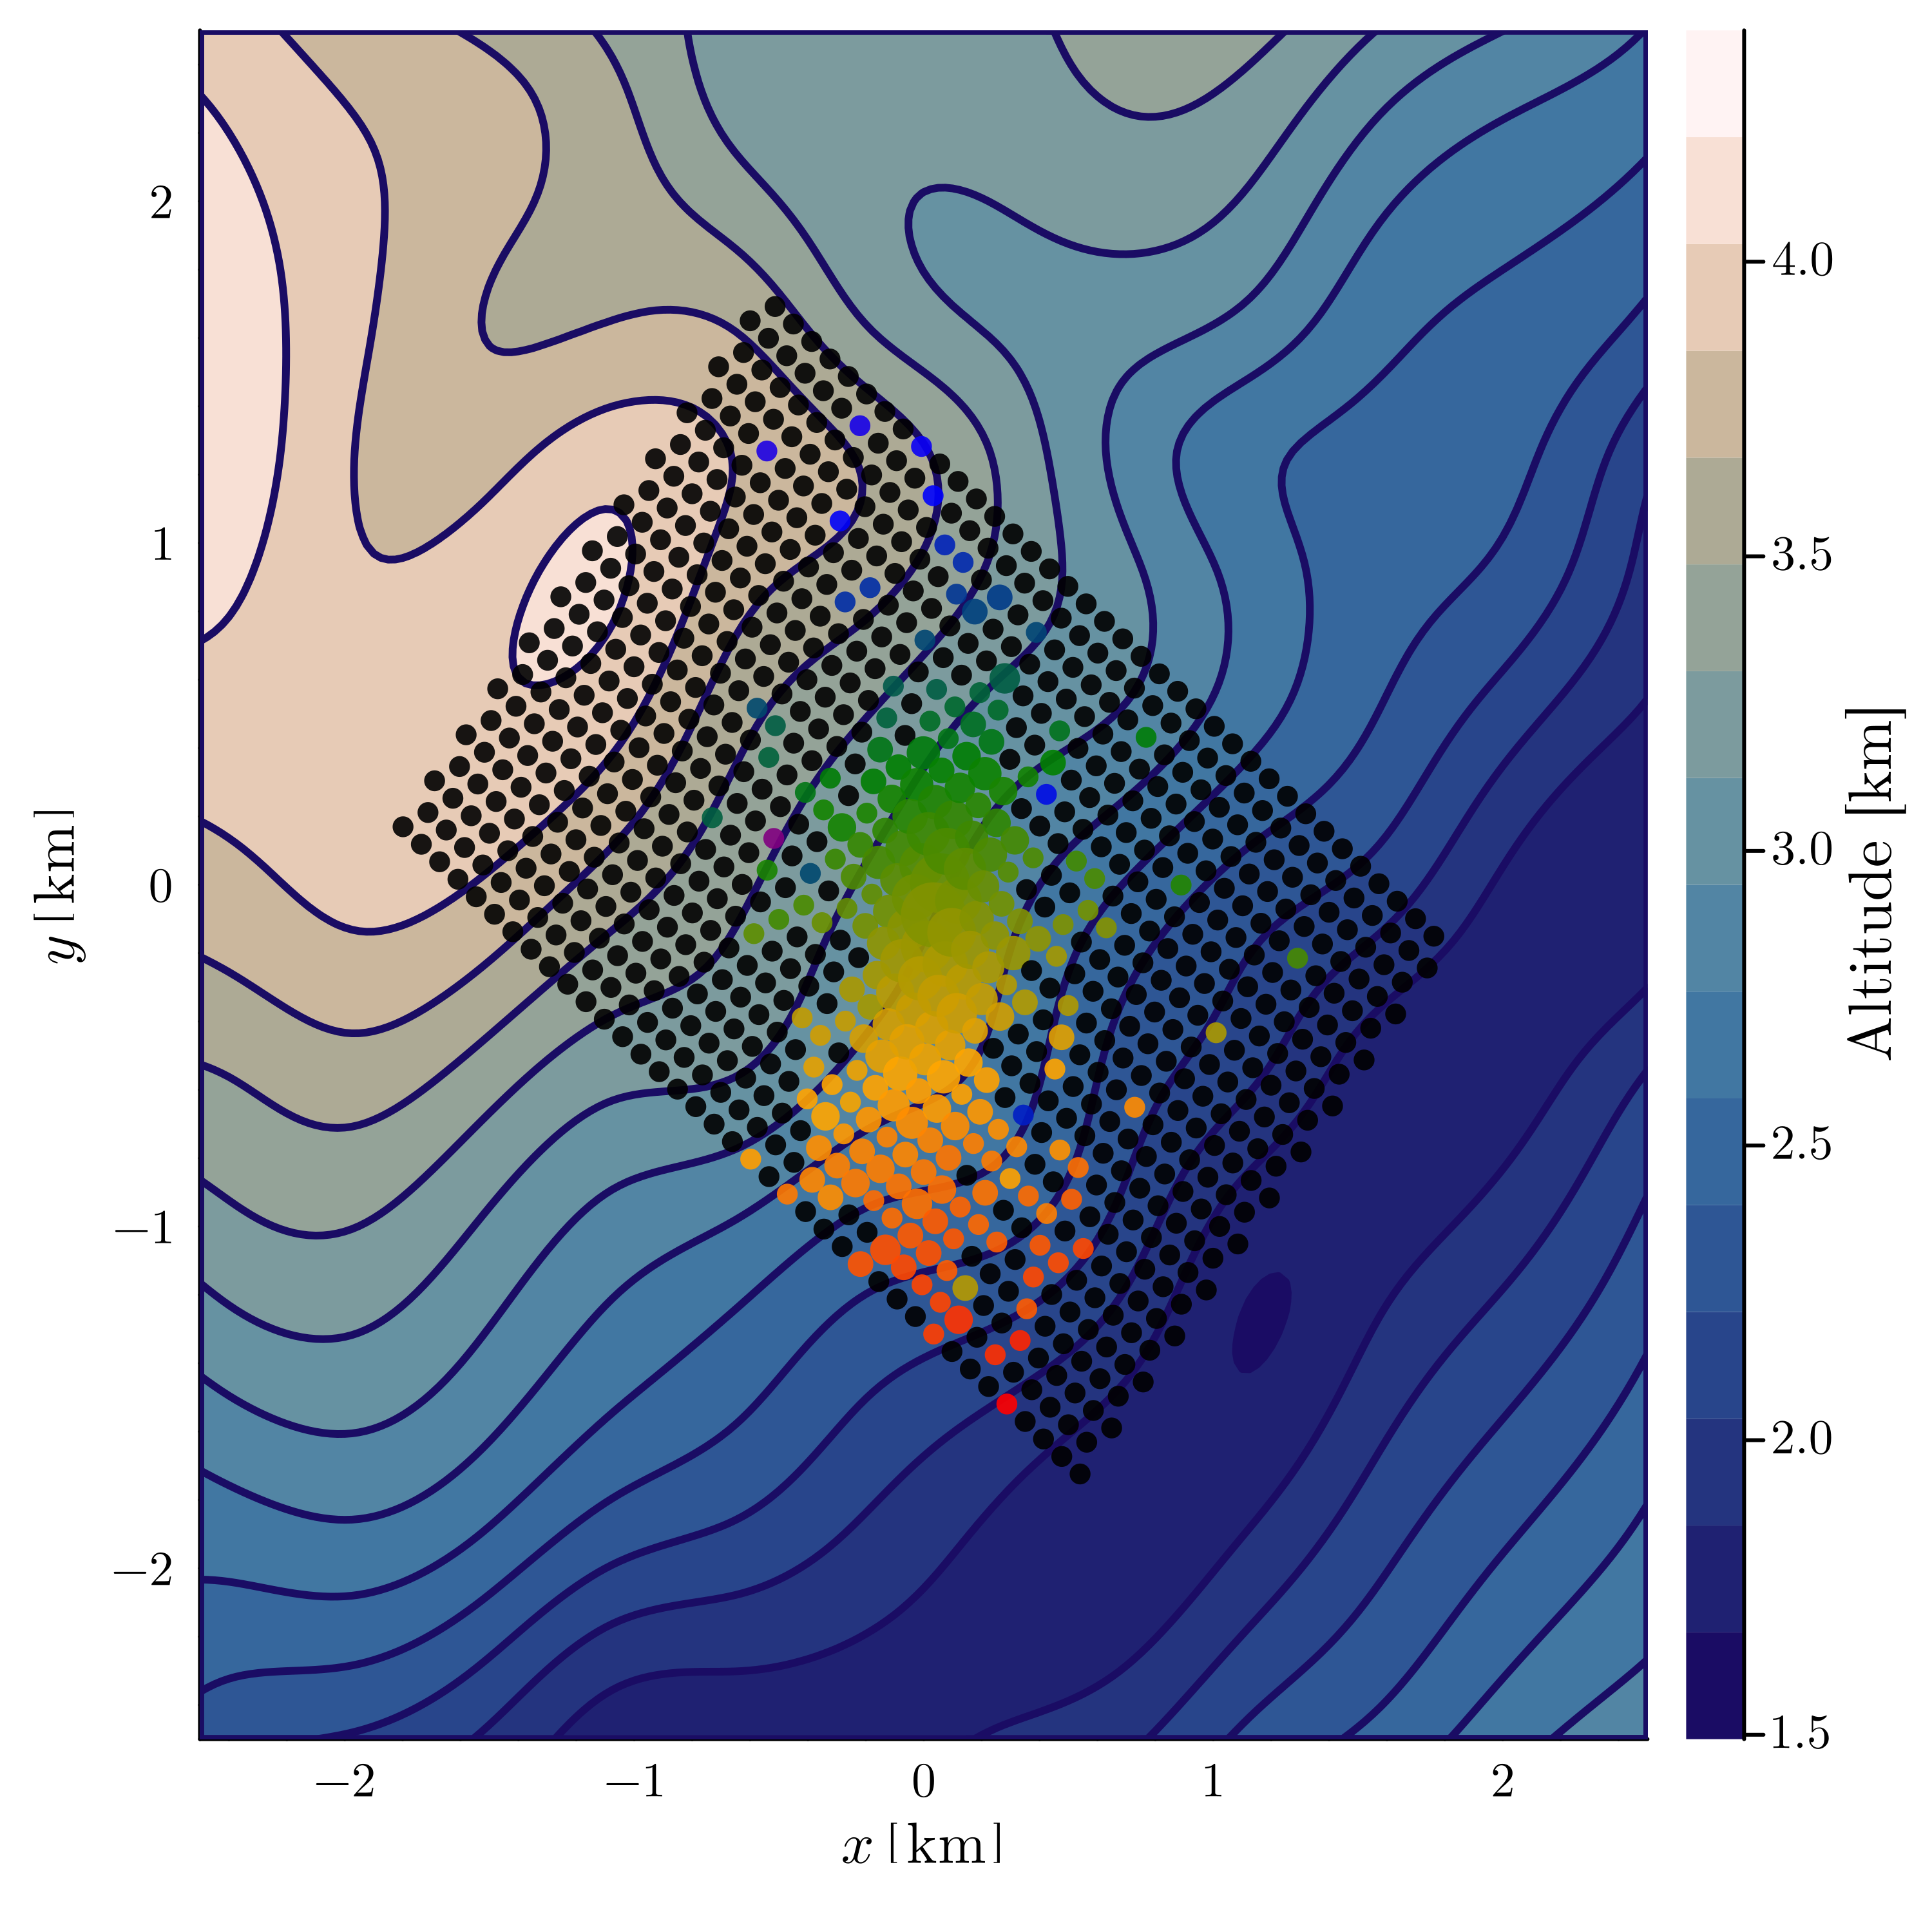

In [9]:
event_number = 17452
hit_map = hit_maps[string(event_number)]
plt = plot_topographic_map(geo, contour_color=palette(:lapaz, rev=false))
plot_modules!(plt, modules, hit_map, time_cmap=cgrad(:rainbow, rev=true))

## We can extend these to make gifs

All the previous arguments for changing colors and border apply here.
You can also provide the `filename` kwarg to specify a place to save the gif, with the default being `./figures/tambo_event.gif`.
Additionally, `nframe` will adjust the time step of the gif, and `fps` will adjust the frames per second of the gif

In [ ]:
function plot_event_gif(
    geo,
    modules,
    hit_map;
    contour_color=palette(:lapaz),
    time_cmap=cgrad(:rainbow, rev=true),
    module_color=colorant"black",
    filename="./figures/tambo_event.gif",
    fps=15,
    nframe=100,
    xmin=-2.5units.km,
    xmax=2.5units.km,
    ymin=-2.5units.km,
    ymax=2.5units.km,
)
    tmin, tmax = find_time_range(hit_map)
    tcuts = LinRange(tmin, tmax, nframe)
    anim = @animate for tcut in tcuts
        plt = plot_topographic_map(
            geo,
            contour_color=contour_color,
            xmin=xmin,
            xmax=xmax,
            ymin=ymin,
            ymax=ymax
        )
        plot_modules!(
            plt,
            modules,
            hit_map,
            tcut=tcut,
            module_color=module_color,
            time_cmap=time_cmap
        )
    end
    gif(anim, filename, fps=fps)
end

In [ ]:
plot_event_gif(geo, modules, hit_map, fps=15, nframe=150)